# Self-Supervised ResNet-15

We are given two datasets, `unlabelled` with only features 'jet' of shape (60000, 125, 125, 8), and `labelled` with two features 'jet' and 'Y' of shapes (10000, 125 125, 8) and (10000, 1)

In this notebook, we make a Self-Supervised ResNet-15 following the Barlow Twins training scheme. 

In [ ]:
# import os
# import wandb
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()
# os.environ["WANDB_API_KEY"] = user_secrets.get_secret("wandb-key")

In [ ]:
import os
import gc
import threading
import time
import h5py
import torch
import torch.nn as nn
import numpy as np
import wandb
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from tqdm import tqdm

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In the paper, it is given that we are required to augment the training data with meaningful transformations. The following classes are responsible for loading and augmenting the dataset. 

In [ ]:
class JetDataset(Dataset):
    def __init__(self, h5_path, transform=None, num_samples=None):
        self.h5_path = h5_path
        self.transform = transform
        self.file = None

        # Get dataset size without loading everything
        with h5py.File(self.h5_path, "r") as f:
            self.length = f["jet"].shape[0]
            self.sample_shape = f["jet"].shape[1:]

        if num_samples is not None:
            self.length = min(self.length, num_samples)

    def _get_file(self):
        if self.file is None:
            self.file = h5py.File(self.h5_path, "r", swmr=True)  # Open in SWMR mode
        return self.file

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Load a single sample on demand
        f = self._get_file()
        x = f["jet"][idx]

        # Convert to tensor
        x = torch.from_numpy(x).float()

        # Apply two different augmentations for Barlow Twins
        if self.transform:
            x1 = self.transform(x, is_hard=False)
            x2 = self.transform(x, is_hard=True)
            return x1, x2

        return x

    def __del__(self):
        """Ensure the file is closed properly when dataset is deleted."""
        if self.file is not None:
            self.file.close()
            self.file = None


class JetTransform:
    def __init__(self):
        pass

    def __call__(self, x, is_hard=False):
        # x shape: (125, 125, 8)

        # Base augmentations for all views
        # Random flip
        if torch.rand(1) > 0.5:
            x = torch.flip(x, [0])  # Horizontal flip
        if torch.rand(1) > 0.5:
            x = torch.flip(x, [1])  # Vertical flip

        # Random rotation (90, 180, 270 degrees)
        rot_choice = torch.randint(0, 4, (1,)).item()
        if rot_choice > 0:
            x = torch.rot90(x, k=rot_choice, dims=[0, 1])

        # Additional harder augmentations for the second view
        if is_hard:
            # Stronger noise
            noise = torch.randn_like(x) * 0.05  # Increased from 0.02
            x = x + noise

            # Random cutout (set random small patches to 0) - more aggressive
            h, w = x.shape[0], x.shape[1]
            # Multiple cutouts for harder augmentation
            for _ in range(2):
                if torch.rand(1) > 0.3:  # Increased probability
                    size = int(min(h, w) * 0.2)  # Larger patch size (20% vs 15%)
                    # Random patch coordinates
                    top = torch.randint(0, h - size + 1, (1,)).item()
                    left = torch.randint(0, w - size + 1, (1,)).item()
                    # Apply cutout
                    x[top : top + size, left : left + size, :] = 0

            # Random intensity scaling
            if torch.rand(1) > 0.5:
                scale_factor = torch.FloatTensor(1).uniform_(0.8, 1.2)
                x = x * scale_factor

        else:
            # Lighter augmentations for the first view
            if torch.rand(1) > 0.5:
                noise = torch.randn_like(x) * 0.02
                x = x + noise

            # Single smaller cutout with lower probability
            if torch.rand(1) > 0.7:
                h, w = x.shape[0], x.shape[1]
                size = int(min(h, w) * 0.15)
                top = torch.randint(0, h - size + 1, (1,)).item()
                left = torch.randint(0, w - size + 1, (1,)).item()
                x[top : top + size, left : left + size, :] = 0

        return x

From here, we start building the actual ResNet-15 model

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet15(nn.Module):
    def __init__(self, in_channels=8, num_blocks=None):
        super().__init__()
        if num_blocks is None:
            num_blocks = [2, 2, 2, 1]
        self.in_channels = 64

        self.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # 4 layers with num_blocks residual blocks each
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # Input shape: (B, 125, 125, 8)
        # Rearrange to: (B, 8, 125, 125)
        x = x.permute(0, 3, 1, 2)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        return out


# Barlow Twins Components
class BarlowTwinsProjectionHead(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=1024, output_dim=1024):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.projection(x)


def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


class BarlowTwinsLoss(nn.Module):
    def __init__(self, lambda_coeff=5e-3):
        super().__init__()
        self.lambda_coeff = lambda_coeff

    def forward(self, z1, z2):
        # Normalize along the batch dimension
        z1_norm = (z1 - z1.mean(0)) / (z1.std(0) + 1e-5)
        z2_norm = (z2 - z2.mean(0)) / (z2.std(0) + 1e-5)

        batch_size = z1.size(0)

        # Cross-correlation matrix
        c = torch.matmul(z1_norm.T, z2_norm) / batch_size

        # Loss computation
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()

        loss = on_diag + self.lambda_coeff * off_diag
        return loss, on_diag, off_diag  # Return components for logging


# Complete Barlow Twins Model
class BarlowTwinsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = ResNet15(in_channels=8)
        self.projection_head = BarlowTwinsProjectionHead(
            input_dim=512, hidden_dim=1024, output_dim=1024
        )
        self.criterion = BarlowTwinsLoss(lambda_coeff=5e-3)

    def forward(self, x):
        features = self.backbone(x)
        projections = self.projection_head(features)
        return projections

    def training_step(self, batch):
        x1, x2 = batch

        z1 = self.forward(x1)
        z2 = self.forward(x2)

        loss, on_diag, off_diag = self.criterion(z1, z2)
        return loss, on_diag, off_diag

    def validation_step(self, batch):
        # For early stopping validation
        return self.training_step(batch)


We define early stopping class and a checkpointer

In [ ]:
class EarlyStoppingAfterWarmup:
    """Early stopping with a warmup period to avoid stopping during LR ramp-up"""

    def __init__(self, patience=5, min_delta=0, warmup_epochs=5):
        self.patience = patience
        self.min_delta = min_delta
        self.warmup_epochs = warmup_epochs
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def __call__(self, epoch, val_loss):
        if epoch < self.warmup_epochs:
            return False

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            print(f"Early stopping counter: {self.counter}/{self.patience}")
            wandb.log({"early_stopping_counter": self.counter})
            if self.counter >= self.patience:
                print(
                    f"Early stopping triggered! No improvement for {self.patience} epochs."
                )
                self.early_stop = True
                return True
        return False


class AsyncCheckpointer:
    """Performs checkpointing asynchronously in a separate thread"""

    def __init__(self, save_dir="checkpoints"):
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        self.current_thread = None

    def save_checkpoint(self, state, filename):
        
        # Wait for any previous checkpointing to finish
        if self.current_thread is not None and self.current_thread.is_alive():
            self.current_thread.join()

        # Create a new thread for saving
        self.current_thread = threading.Thread(
            target=self._save_checkpoint_thread, args=(state, filename)
        )
        self.current_thread.start()

    def _save_checkpoint_thread(self, state, filename):
        try:
            filepath = os.path.join(self.save_dir, filename)
            
            # First save to a temporary file
            tmp_filepath = filepath + ".tmp"
            torch.save(state, tmp_filepath)
            
            # Then rename to the actual file (atomic operation)
            if os.path.exists(filepath):
                os.remove(filepath)
            os.rename(tmp_filepath, filepath)
            print(f"Checkpoint saved: {filename}")

            # Log the checkpoint to wandb
            wandb.save(filepath)

            # Create a wandb artifact for the model checkpoint
            artifact = wandb.Artifact(
                name=f"model-{filename}",
                type="model",
                description=f"Model checkpoint at {filename}",
            )
            artifact.add_file(filepath)
            wandb.log_artifact(artifact)

        except Exception as e:
            print(f"Error saving checkpoint: {e}")


In [ ]:
def super_convergence_scheduler(epoch, total_epochs=30):
    """
    Implements the super-convergence learning rate schedule
    """
    base_lr = 1e-4  # Starting LR
    max_lr = 3e-3  # Maximum LR
    min_lr = 5e-5  # Minimum LR before final cooldown

    # Phase 1: Warmup from base_lr to max_lr (30% of training)
    if epoch < 0.3 * total_epochs:
        return base_lr + (max_lr - base_lr) * (epoch / (0.3 * total_epochs))
    # Phase 2: Cosine annealing from max_lr to min_lr (60% of training)
    elif epoch < 0.9 * total_epochs:
        # Normalize epoch to 0-1 range for this phase
        normalized_epoch = (epoch - 0.3 * total_epochs) / (0.6 * total_epochs)
        return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * normalized_epoch))
    # Phase 3: Final cooldown from min_lr to near-zero (10% of training)
    else:
        # Normalize epoch to 0-1 range for this phase
        normalized_epoch = (epoch - 0.9 * total_epochs) / (0.1 * total_epochs)
        return min_lr * (1 - normalized_epoch)


def create_validation_dataloader(dataset, batch_size, num_samples=1000):
    """Create a small validation set from the training data"""
    # Create indices for validation
    val_indices = torch.randperm(len(dataset))[:num_samples]

    # Create a subset of the dataset for validation
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    # Create dataloader
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    return val_loader


def validate(model, val_loader, device):
    """Run validation on a batch of data"""
    model.eval()
    val_loss = 0.0
    on_diag_sum = 0.0
    off_diag_sum = 0.0

    with torch.no_grad():
        for batch in val_loader:
            batch = [x.to(device) for x in batch]
            with autocast("cuda"):
                loss, on_diag, off_diag = model.validation_step(batch)
            val_loss += loss.item()
            on_diag_sum += on_diag.item()
            off_diag_sum += off_diag.item()

    model.train()
    return (
        val_loss / len(val_loader),
        on_diag_sum / len(val_loader),
        off_diag_sum / len(val_loader),
    )

Now, the main training loop. We are training with mixed precision to speed it up.

In [ ]:
def main():
    wandb.init(
        project="barlow-twins-resnet15",
        name="barlow-twins-jet-data",
        config={
            "architecture": "ResNet15",
            "dataset": "unlabelled.h5",
            "epochs": 30,
            "batch_size": 64,
            "optimizer": "AdamW",
            "weight_decay": 0.05,
            "scheduler": "super_convergence",
            "base_lr": 1e-4,
            "max_lr": 3e-3,
            "min_lr": 5e-5,
            "lambda_coeff": 5e-3,
            "projection_dim": 1024,
        },
    )

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    wandb.config.update({"device": str(device)})

    # Create model and move to device
    model = BarlowTwinsModel().to(device)

    # Set up wandb to watch the model
    wandb.watch(model, log="all", log_freq=100)

    # Set up dataset with augmentations
    transform = JetTransform()
    dataset = JetDataset("/kaggle/input/jet-vit-cms/unlabelled.h5", transform=transform)
    wandb.config.update({"dataset_size": len(dataset)})

    # Get CPU count for workers
    cpu_count = os.cpu_count()
    num_workers = max(1, cpu_count - 2)  # Leaving some CPUs free
    print(f"Using {num_workers} data loader workers based on {cpu_count} CPUs")
    wandb.config.update({"num_workers": num_workers})

    # Set batch size
    batch_size = 64
    wandb.config.update({"batch_size": batch_size})

    # Create data loader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False,
        persistent_workers=True if num_workers > 0 else False,
    )

    # Create a small validation set for early stopping
    val_dataloader = create_validation_dataloader(dataset, batch_size=batch_size)

    # Optimizer is AdamW with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

    # Set up Super-Convergence learning rate scheduler
    total_epochs = 30

    # Set up early stopping after warmup
    early_stopping = EarlyStoppingAfterWarmup(
        patience=4, min_delta=0.001, warmup_epochs=9
    )

    # Set up async checkpointer
    checkpointer = AsyncCheckpointer()

    # Set up mixed precision training
    scaler = GradScaler()

    # Start timing the training
    start_time = time.time()

    # Training loop
    model.train()
    best_val_loss = float("inf")

    # Create a wandb Table for tracking validation results
    validation_table = wandb.Table(
        columns=[
            "epoch",
            "train_loss",
            "val_loss",
            "on_diag_loss",
            "off_diag_loss",
            "lr",
        ]
    )

    for epoch in range(total_epochs):
        
        # Update learning rate according to super convergence schedule
        current_lr = super_convergence_scheduler(epoch, total_epochs)
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr

        # Log the current LR
        wandb.log({"learning_rate": current_lr, "epoch": epoch})

        # Training progress bar (tqdm)
        progress_bar = tqdm(
            enumerate(dataloader),
            total=len(dataloader),
            desc=f"Epoch {epoch + 1}/{total_epochs}",
        )

        epoch_loss = 0.0
        epoch_on_diag = 0.0
        epoch_off_diag = 0.0

        for batch_idx, batch in progress_bar:
            
            # Move batch to device
            batch = [x.to(device) for x in batch]

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass with mixed precision
            with autocast("cuda"):
                loss, on_diag, off_diag = model.training_step(batch)

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Update statistics
            epoch_loss += loss.item()
            epoch_on_diag += on_diag.item()
            epoch_off_diag += off_diag.item()

            # Update progress bar
            progress_bar.set_postfix(
                {"loss": epoch_loss / (batch_idx + 1), "lr": f"{current_lr:.6f}"}
            )

            # Log batch metrics to wandb every few batches
            if batch_idx % 10 == 0:
                wandb.log(
                    {
                        "batch_loss": loss.item(),
                        "batch_on_diag_loss": on_diag.item(),
                        "batch_off_diag_loss": off_diag.item(),
                        "batch": batch_idx + epoch * len(dataloader),
                    }
                )

        # Calculate average epoch loss
        avg_train_loss = epoch_loss / len(dataloader)
        avg_on_diag = epoch_on_diag / len(dataloader)
        avg_off_diag = epoch_off_diag / len(dataloader)

        # Calculate validation loss for early stopping
        val_loss, val_on_diag, val_off_diag = validate(model, val_dataloader, device)

        # Log epoch metrics to wandb
        wandb.log(
            {
                "train_loss": avg_train_loss,
                "val_loss": val_loss,
                "train_on_diag_loss": avg_on_diag,
                "train_off_diag_loss": avg_off_diag,
                "val_on_diag_loss": val_on_diag,
                "val_off_diag_loss": val_off_diag,
                "epoch": epoch,
            }
        )

        # Add data to validation table
        validation_table.add_data(
            epoch, avg_train_loss, val_loss, val_on_diag, val_off_diag, current_lr
        )

        print(
            f"Epoch {epoch + 1}/{total_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f} - LR: {current_lr:.6f}"
        )

        # Save checkpoint only if it's the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpointer.save_checkpoint(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": best_val_loss,
                },
                "barlow_twins_best.pt",
            )

            # Log the best model to wandb
            wandb.run.summary["best_val_loss"] = best_val_loss
            wandb.run.summary["best_epoch"] = epoch

        # Check for early stopping (but not during warmup phase)
        if early_stopping(epoch, val_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            wandb.run.summary["stopped_epoch"] = epoch
            break

        # Save regular checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpointer.save_checkpoint(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": val_loss,
                },
                f"barlow_twins_resnet15_epoch{epoch + 1}.pt",
            )

        # Clean up memory
        torch.cuda.empty_cache()
        gc.collect()

    # Save final model
    torch.save(model.state_dict(), "barlow_twins_resnet15_final.pt")

    # Log the final model to wandb
    final_artifact = wandb.Artifact(
        name="model-final", type="model", description="Final trained model"
    )
    final_artifact.add_file("barlow_twins_resnet15_final.pt")
    wandb.log_artifact(final_artifact)

    # Log the validation results table
    wandb.log({"validation_results": validation_table})

    # Report total training time
    total_time = time.time() - start_time
    print(f"Training completed in {total_time / 60:.2f} minutes! Final model saved.")
    wandb.run.summary["training_time_minutes"] = total_time / 60

    # Close wandb run
    wandb.finish()


if __name__ == "__main__":
    main()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ankittriescoding (ankittriescoding-indian-institute-of-technology-kharagpur). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250403_095517-f8yw81as
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run barlow-twins-jet-data
wandb: ⭐️ View project at https://wandb.ai/ankittriescoding-indian-institute-of-technology-kharagpur/barlow-twins-resnet15
wandb: 🚀 View run at https://wandb.ai/ankittriescoding-indian-institute-of-technology-kharagpur/barlow-twins-resnet15/runs/f8yw81as


Using device: cuda
Using 2 data loader workers based on 4 CPUs


Epoch 1/30: 100%|██████████| 938/938 [10:59<00:00,  1.42it/s, loss=140, lr=0.000100]


Epoch 1/30 - Train Loss: 140.0518 - Val Loss: 126.5455 - LR: 0.000100
Checkpoint saved: barlow_twins_best.pt


Epoch 2/30: 100%|██████████| 938/938 [10:56<00:00,  1.43it/s, loss=106, lr=0.000422]


Epoch 2/30 - Train Loss: 105.9351 - Val Loss: 116.5946 - LR: 0.000422
Checkpoint saved: barlow_twins_best.pt


Epoch 3/30: 100%|██████████| 938/938 [10:56<00:00,  1.43it/s, loss=101, lr=0.000744]


Epoch 3/30 - Train Loss: 100.9820 - Val Loss: 108.3888 - LR: 0.000744
Checkpoint saved: barlow_twins_best.pt


Epoch 4/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=97.2, lr=0.001067]


Epoch 4/30 - Train Loss: 97.2099 - Val Loss: 105.2844 - LR: 0.001067
Checkpoint saved: barlow_twins_best.pt


Epoch 5/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=94.4, lr=0.001389]


Epoch 5/30 - Train Loss: 94.3983 - Val Loss: 103.9144 - LR: 0.001389
Checkpoint saved: barlow_twins_best.pt
Checkpoint saved: barlow_twins_resnet15_epoch5.pt


Epoch 6/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=93.3, lr=0.001711]


Epoch 6/30 - Train Loss: 93.2811 - Val Loss: 105.5006 - LR: 0.001711


Epoch 7/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=93.1, lr=0.002033]


Epoch 7/30 - Train Loss: 93.0775 - Val Loss: 110.4829 - LR: 0.002033


Epoch 8/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=92.4, lr=0.002356]


Epoch 8/30 - Train Loss: 92.3706 - Val Loss: 99.9348 - LR: 0.002356
Checkpoint saved: barlow_twins_best.pt


Epoch 9/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=91.8, lr=0.002678]


Epoch 9/30 - Train Loss: 91.8457 - Val Loss: 100.9075 - LR: 0.002678


Epoch 10/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=91.6, lr=0.003000]


Epoch 10/30 - Train Loss: 91.5668 - Val Loss: 100.4657 - LR: 0.003000
Checkpoint saved: barlow_twins_resnet15_epoch10.pt


Epoch 11/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=90.3, lr=0.002978]


Epoch 11/30 - Train Loss: 90.3400 - Val Loss: 99.5314 - LR: 0.002978
Checkpoint saved: barlow_twins_best.pt


Epoch 12/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=89.6, lr=0.002911]


Epoch 12/30 - Train Loss: 89.6125 - Val Loss: 112.0947 - LR: 0.002911
Early stopping counter: 1/4


Epoch 13/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=88.9, lr=0.002802]


Epoch 13/30 - Train Loss: 88.9471 - Val Loss: 102.6259 - LR: 0.002802
Early stopping counter: 2/4


Epoch 14/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=88.1, lr=0.002655]


Epoch 14/30 - Train Loss: 88.1191 - Val Loss: 98.9569 - LR: 0.002655
Checkpoint saved: barlow_twins_best.pt


Epoch 15/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=87.3, lr=0.002473]


Epoch 15/30 - Train Loss: 87.3062 - Val Loss: 115.1848 - LR: 0.002473
Early stopping counter: 1/4
Checkpoint saved: barlow_twins_resnet15_epoch15.pt


Epoch 16/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=86.6, lr=0.002263]


Epoch 16/30 - Train Loss: 86.5693 - Val Loss: 117.6125 - LR: 0.002263
Early stopping counter: 2/4


Epoch 17/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=85.6, lr=0.002029]


Epoch 17/30 - Train Loss: 85.6136 - Val Loss: 189.4366 - LR: 0.002029
Early stopping counter: 3/4


Epoch 18/30: 100%|██████████| 938/938 [10:57<00:00,  1.43it/s, loss=85, lr=0.001781]


Epoch 18/30 - Train Loss: 84.9952 - Val Loss: 110.5056 - LR: 0.001781
Early stopping counter: 4/4
Early stopping triggered! No improvement for 4 epochs.
Early stopping triggered at epoch 18
Training completed in 200.73 minutes! Final model saved.


wandb: uploading artifact model-final
wandb: uploading checkpoints/barlow_twins_resnet15_epoch5.pt; uploading checkpoints/barlow_twins_resnet15_epoch10.pt; uploading checkpoints/barlow_twins_resnet15_epoch15.pt; uploading checkpoints/barlow_twins_best.pt
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  batch ▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇████
wandb:             batch_loss █▅▃▃▄▃▃▃▃▂▃▂▃▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
wandb:    batch_off_diag_loss █▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     batch_on_diag_loss █▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: early_stopping_counter ▁▃▁▃▆█
wandb:                  epoch ▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
wandb:          learning_rate ▁▂▃▃▄▅▆▆▇████▇▇▆▆▅
wandb:             train_loss █▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
wandb:    train_off_diag_loss █▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:     train_on_diag_loss █▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
wandb:               val_loss ▃▂▂▁▁▂▂▁▁▁▁▂▁▁▂▂

We are done with the self-supervised training. Now, it's time for fine-tuning the model, and creating a model from scratch using only the labelled dataset. At the end we will compare which odel is better.

In [ ]:
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Here, we define `SupervisedModel` to load the self-supervised model. 

In [ ]:
class SupervisedModel(nn.Module):
    def __init__(self, backbone, num_classes=1):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)


# Dataset class for labelled data
class JetDatasetFinetune(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]

        if self.transform:
            x = self.transform(x)

        return x, y


We define other essential modules in this section

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.best_state = None

    def __call__(self, val_loss, model_state):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state = model_state
            return False
        else:
            self.counter += 1
            print(f"Early stopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                return True
            return False


def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))

    for batch_idx, (inputs, targets) in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        progress_bar.set_description(
            f"Loss: {running_loss / (batch_idx + 1):.4f}, Acc: {100.0 * correct / total:.2f}%"
        )

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()

            # Calculate predictions
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc


Now, the final training loop.

Using device: cuda
Loading labelled dataset...
Loaded data shapes - Jets: (10000, 125, 125, 8), Labels: (10000, 1)
Fine-tuning Pre-trained Model...


<ipython-input-7-1d2451ed6608>:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


Phase 1: Training classifier with frozen backbone

Epoch 1/10


Loss: 0.6262, Acc: 69.67%: 100%|██████████| 125/125 [01:35<00:00,  1.30it/s]



Epoch 2/10


Loss: 0.5617, Acc: 74.14%: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]



Epoch 3/10


Loss: 0.5353, Acc: 75.26%: 100%|██████████| 125/125 [01:35<00:00,  1.32it/s]



Epoch 4/10


Loss: 0.5228, Acc: 75.51%: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s]



Epoch 5/10


Loss: 0.5171, Acc: 75.79%: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s]



Epoch 6/10


Loss: 0.5103, Acc: 76.15%: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s]



Epoch 7/10


Loss: 0.5098, Acc: 75.96%: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s]



Epoch 8/10


Loss: 0.5061, Acc: 76.51%: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s]



Epoch 9/10


Loss: 0.5061, Acc: 76.65%: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s]



Epoch 10/10


Loss: 0.5058, Acc: 76.50%: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s]



Phase 2: Fine-tuning entire model

Epoch 1/15


Loss: 0.4960, Acc: 77.25%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 2/15


Loss: 0.4623, Acc: 79.58%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 3/15


Loss: 0.4152, Acc: 83.35%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 4/15


Loss: 0.3681, Acc: 85.74%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 5/15


Loss: 0.3428, Acc: 87.12%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 6/15


Loss: 0.3268, Acc: 87.60%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 7/15


Loss: 0.3179, Acc: 87.76%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 8/15


Loss: 0.3111, Acc: 88.09%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 9/15


Loss: 0.3025, Acc: 88.29%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 10/15


Loss: 0.2990, Acc: 88.45%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 11/15


Loss: 0.2982, Acc: 88.22%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 12/15


Loss: 0.2944, Acc: 88.51%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 13/15


Loss: 0.2978, Acc: 88.19%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]


Early stopping counter: 1/5

Epoch 14/15


Loss: 0.2917, Acc: 88.80%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]



Epoch 15/15


Loss: 0.2956, Acc: 88.50%: 100%|██████████| 125/125 [04:32<00:00,  2.18s/it]


Early stopping counter: 1/5

Training Model from Scratch...

Epoch 1/25


Loss: 0.3964, Acc: 82.94%: 100%|██████████| 125/125 [04:31<00:00,  2.17s/it]



Epoch 2/25


Loss: 0.2923, Acc: 87.92%: 100%|██████████| 125/125 [04:31<00:00,  2.18s/it]


Early stopping counter: 1/7

Epoch 3/25


Loss: 0.2782, Acc: 89.08%: 100%|██████████| 125/125 [04:31<00:00,  2.17s/it]


Early stopping counter: 2/7

Epoch 4/25


Loss: 0.2675, Acc: 89.72%: 100%|██████████| 125/125 [04:31<00:00,  2.17s/it]


Early stopping counter: 3/7

Epoch 5/25


Loss: 0.2586, Acc: 89.66%: 100%|██████████| 125/125 [04:31<00:00,  2.17s/it]



Epoch 6/25


Loss: 0.2503, Acc: 90.10%: 100%|██████████| 125/125 [04:31<00:00,  2.17s/it]


Early stopping counter: 1/7

Epoch 7/25


Loss: 0.2359, Acc: 90.41%: 100%|██████████| 125/125 [04:31<00:00,  2.17s/it]



Epoch 8/25


Loss: 0.2206, Acc: 91.36%: 100%|██████████| 125/125 [04:31<00:00,  2.17s/it]



Epoch 9/25


Loss: 0.2033, Acc: 91.88%: 100%|██████████| 125/125 [04:31<00:00,  2.17s/it]


Early stopping counter: 1/7

Epoch 10/25


Loss: 0.1877, Acc: 92.86%: 100%|██████████| 125/125 [04:31<00:00,  2.18s/it]


Early stopping counter: 2/7

Epoch 11/25


Loss: 0.1567, Acc: 93.94%: 100%|██████████| 125/125 [04:31<00:00,  2.18s/it]


Early stopping counter: 3/7

Epoch 12/25


Loss: 0.1270, Acc: 95.28%: 100%|██████████| 125/125 [04:31<00:00,  2.17s/it]


Early stopping counter: 4/7

Epoch 13/25


Loss: 0.0919, Acc: 96.75%: 100%|██████████| 125/125 [04:31<00:00,  2.17s/it]


Early stopping counter: 5/7

Epoch 14/25


Loss: 0.0642, Acc: 97.81%: 100%|██████████| 125/125 [04:31<00:00,  2.17s/it]


Early stopping counter: 6/7

Epoch 15/25


Loss: 0.0345, Acc: 99.05%: 100%|██████████| 125/125 [04:31<00:00,  2.18s/it]


Early stopping counter: 7/7

--Model Comparison--
Fine-tuned model - Val Loss: 0.3033, Val Acc: 88.70%
From-scratch model - Val Loss: 0.6650, Val Acc: 81.35%
The fine-tuned model performed better by 7.35%!
This demonstrates the value of self-supervised pre-training.


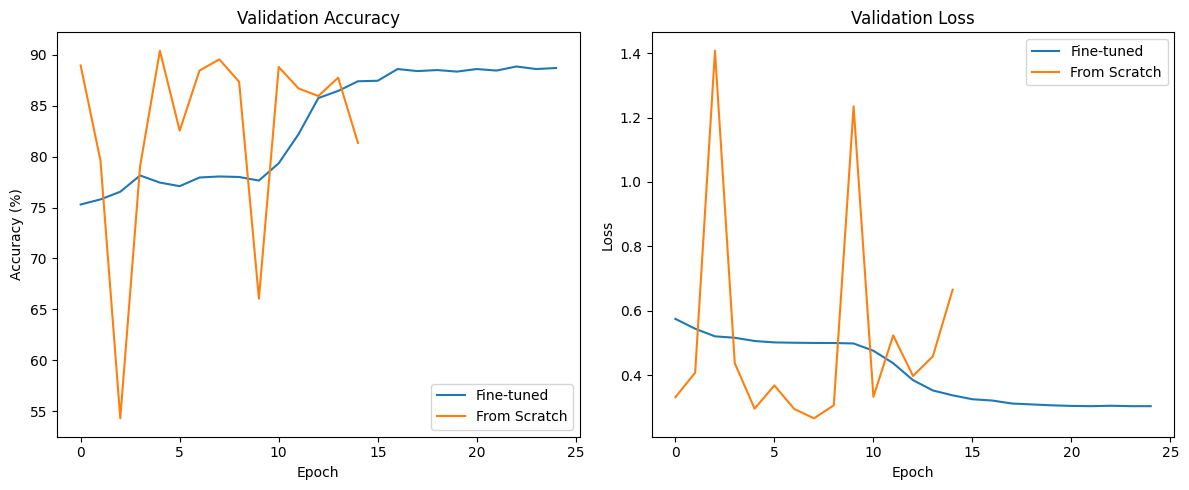

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load labelled data
    print("Loading labelled dataset...")
    with h5py.File("/kaggle/input/jet-vit-cms/labelled.h5", "r") as f:
        jet_data = np.array(f["jet"])
        labels = np.array(f["Y"])

    print(f"Loaded data shapes - Jets: {jet_data.shape}, Labels: {labels.shape}")

    # Split into train (80%) and validation (20%)
    train_jet, val_jet, train_labels, val_labels = train_test_split(
        jet_data, labels, test_size=0.2, random_state=42
    )

    # Convert to tensors
    train_jet = torch.from_numpy(train_jet).float()
    val_jet = torch.from_numpy(val_jet).float()
    train_labels = torch.from_numpy(train_labels).float()
    val_labels = torch.from_numpy(val_labels).float()

    # Create datasets and dataloaders
    train_dataset = JetDatasetFinetune(train_jet, train_labels)
    val_dataset = JetDatasetFinetune(val_jet, val_labels)

    batch_size = 64
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
    )

    # Load pre-trained model
    print("Fine-tuning Pre-trained Model...")

    pretrained_model = BarlowTwinsModel()
    pretrained_model.load_state_dict(
        torch.load(
            "/kaggle/input/selfsupervisedresnet-cmsjet-barlowtwinsloss/pytorch/default/1/barlow_twins_resnet15_final.pt"
        )
    )

    # Create supervised model with pre-trained backbone
    fine_tuned_model = SupervisedModel(pretrained_model.backbone)
    fine_tuned_model.to(device)

    # Freeze backbone initially
    for param in fine_tuned_model.backbone.parameters():
        param.requires_grad = False

    # Training settings
    criterion = nn.BCEWithLogitsLoss()
    optimizer = AdamW(
        filter(lambda p: p.requires_grad, fine_tuned_model.parameters()),
        lr=1e-3,
        weight_decay=0.01,
    )
    scheduler = CosineAnnealingLR(optimizer, T_max=10)
    early_stopping = EarlyStopping(patience=5)

    # Phase 1: Train only classifier
    print("Phase 1: Training classifier with frozen backbone")
    ft_losses, ft_accs, ft_val_losses, ft_val_accs = [], [], [], []

    for epoch in range(10):
        print(f"\nEpoch {epoch + 1}/10")
        loss, acc = train_one_epoch(
            fine_tuned_model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc = evaluate(fine_tuned_model, val_loader, criterion, device)

        ft_losses.append(loss)
        ft_accs.append(acc)
        ft_val_losses.append(val_loss)
        ft_val_accs.append(val_acc)

        scheduler.step()

        if early_stopping(val_loss, fine_tuned_model.state_dict()):
            fine_tuned_model.load_state_dict(early_stopping.best_state)
            break

    # Phase 2: Fine-tune entire model
    print("\nPhase 2: Fine-tuning entire model")
    # Unfreeze backbone
    for param in fine_tuned_model.backbone.parameters():
        param.requires_grad = True

    optimizer = AdamW(fine_tuned_model.parameters(), lr=1e-5, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=15)
    early_stopping = EarlyStopping(patience=5)

    for epoch in range(15):
        print(f"\nEpoch {epoch + 1}/15")
        loss, acc = train_one_epoch(
            fine_tuned_model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc = evaluate(fine_tuned_model, val_loader, criterion, device)

        ft_losses.append(loss)
        ft_accs.append(acc)
        ft_val_losses.append(val_loss)
        ft_val_accs.append(val_acc)

        scheduler.step()

        if early_stopping(val_loss, fine_tuned_model.state_dict()):
            fine_tuned_model.load_state_dict(early_stopping.best_state)
            break

    # Save fine-tuned model
    torch.save(fine_tuned_model.state_dict(), "fine_tuned_model.pt")

    # Clean up memory
    del pretrained_model
    gc.collect()
    torch.cuda.empty_cache()

    # Train from scratch
    print("\nTraining Model from Scratch...")
    scratch_backbone = ResNet15(in_channels=8)
    scratch_model = SupervisedModel(scratch_backbone)
    scratch_model.to(device)

    optimizer = AdamW(scratch_model.parameters(), lr=1e-3, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=25)
    early_stopping = EarlyStopping(patience=7)

    scratch_losses, scratch_accs, scratch_val_losses, scratch_val_accs = [], [], [], []

    for epoch in range(25):
        print(f"\nEpoch {epoch + 1}/25")
        loss, acc = train_one_epoch(
            scratch_model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc = evaluate(scratch_model, val_loader, criterion, device)

        scratch_losses.append(loss)
        scratch_accs.append(acc)
        scratch_val_losses.append(val_loss)
        scratch_val_accs.append(val_acc)

        scheduler.step()

        if early_stopping(val_loss, scratch_model.state_dict()):
            scratch_model.load_state_dict(early_stopping.best_state)
            break

    # Save from-scratch model
    torch.save(scratch_model.state_dict(), "scratch_model.pt")

    # Compare models
    print("\n--Model Comparison--")
    ft_val_loss, ft_val_acc = evaluate(fine_tuned_model, val_loader, criterion, device)
    scratch_val_loss, scratch_val_acc = evaluate(
        scratch_model, val_loader, criterion, device
    )

    print(f"Fine-tuned model - Val Loss: {ft_val_loss:.4f}, Val Acc: {ft_val_acc:.2f}%")
    print(
        f"From-scratch model - Val Loss: {scratch_val_loss:.4f}, Val Acc: {scratch_val_acc:.2f}%"
    )

    # Plot comparison curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ft_val_accs, label="Fine-tuned")
    plt.plot(scratch_val_accs, label="From Scratch")
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(ft_val_losses, label="Fine-tuned")
    plt.plot(scratch_val_losses, label="From Scratch")
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig("model_comparison.png")

    if ft_val_acc > scratch_val_acc:
        print(
            f"The fine-tuned model performed better by {ft_val_acc - scratch_val_acc:.2f}%!"
        )
        print("This demonstrates the value of self-supervised pre-training.")
    else:
        print(
            f"The from-scratch model performed better by {scratch_val_acc - ft_val_acc:.2f}%."
        )


if __name__ == "__main__":
    main()


The finetuned model is saved as `fine_tuned_model.pt` and the model trained from scratch is `scratch_model.pt`